In [ ]:
# Импорт необходимых библиотек для монтирования диска
import os

#==монтирование google drive в colab и просмотр содержимого dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Data/docs_ds/

Mounted at /content/drive
/content/drive/My Drive/Data/docs_ds


**1. Настройка**

***1.1 Импорт и конфигурирование библиотек***

In [ ]:
# Библиотеки для обработки данных.
import numpy as np
import scipy as sp
from scipy.spatial import distance
import pandas as pd

# Библиотеки для визуализации данных.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable


# Библиотеки для моделирования данных.
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils, Input, callbacks
from tensorflow.keras.layers import Conv1D, Dense, Embedding, Flatten, MaxPool1D, Dropout

# Служебные библиотеки.
import re
import math
import time
import shutil


# Определение версий библиотек.
print("Версия NumPy:", np.__version__)
print("Версия Pandas:", pd.__version__)
print("Версия Matplotlib:", matplotlib.__version__)
print("Версия Seaborn:", sns.__version__)
print("Версия Scikit-learn:", sklearn.__version__)
print("Версия TensorFlow:", tf.__version__)

# Настройка NumPy.
# Установка точности до четырёх знаков после запятой.
# Установка `Ширины строки` на значение `Максимум 130 символов в выводе.
# После вывода 130 символов, вывод продолжится на следующей строке.
np.set_printoptions(precision=4, linewidth=130)

# Конфигурация Seaborn.
sns.set_style("whitegrid")  # Установка фона белого цвета и сетки.
sns.set_palette("deep")  # Установка цветовой палитры.
sns.set_context("paper", font_scale=1.25)  # Установка размера шрифта на 1.25 больше обычного.

# Конфигурация Tensorflow.
tf.random.set_seed(100)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

Версия NumPy: 2.0.2
Версия Pandas: 2.2.2
Версия Matplotlib: 3.10.0
Версия Seaborn: 0.13.2
Версия Scikit-learn: 1.6.1
Версия TensorFlow: 2.19.0


***1.2 Задание констант и вспомогательных (служебных) функций***

In [ ]:
# Константы.
DOCS_CSV = "/content/drive/My Drive/Data/preprocessed/preprocessed.csv"
GLOVE_TXT = "/content/drive/My Drive/Data/glove/glove.6B.100d.txt"

LOGS_DIR = "/content/drive/My Drive/Data/logs"
MODELS_DIR = "/content/drive/My Drive/Data/models"
MODEL_FILE = "/content/drive/My Drive/Data/models/epoch-{epoch:02d}_accuracy-{val_accuracy:.4f}.keras"


TYPES_COUNT = 4  # Количество меток типа (класса).
OUTPUT_DIM = 100  # Размерность выходного измерения.

# Предел Epochs для раннего завершения обучения (EarlyStopping).
# Количество эпох без улучшений, после которых обучение будет остановлено.
PATIENCE = 3

# Сопоставление классов и меток
types_map = {'Confidential': 0, 'Internal': 1, 'Public': 2, 'Restricted': 3}

In [ ]:
# Вспомогательные (служебные) функции.

#===Функция сжатия строки путем отображения многоточия между
#   первыми n и последними n символами
def func_viewNValues(row_loc, n=5):
    if row_loc is None:
        return "[]"

    left_hand_symbols = []
    right_hand_symbols = []
    for idx, value in enumerate(row_loc):
        if idx < n:
            left_hand_symbols.append(str(value))
        elif idx >= (len(row_loc) - n):
            right_hand_symbols.append(str(value))

    left_hand_symbols = ", ".join(left_hand_symbols)
    delimeters = ", ..." if len(row_loc) > 2 * n else ""
    right_hand_symbols = f", {', '.join(right_hand_symbols)}" if len(right_hand_symbols) else ""

    return f"[{left_hand_symbols + delimeters + right_hand_symbols}]"

# Lambda-функция, уменьшающая входное 'value' на 'percent' процентов.
decreaseBy = lambda value, percent: value - (percent * value / 100)


#===Функция вычисления косинусного сходства между двумя входными словами
#   на основе их GloVe-векторов
def func_cosineSimilarity(glove_vectors_index_loc, word_1_loc, word_2_loc):

    vector_1 = glove_vectors_index_loc.get(word_1_loc.lower())
    print(f"Вектор GloVe для `{word_1_loc}`: {func_viewNValues(vector_1, 3)}")

    vector_2 = glove_vectors_index_loc.get(word_2_loc.lower())
    print(f"Вектор GloVe для `{word_2_loc}`: {func_viewNValues(vector_2, 3)}")

    cosine_distance = distance.cosine(vector_1, vector_2)
    print(f"Косинусное сходство между '{word_1_loc}' и '{word_2_loc}': {round(cosine_distance, 4)}")


***1.3 Сброс содержимого каталогов***

In [ ]:
# Удаление журналов и сохраненных моделей.
shutil.rmtree(LOGS_DIR, ignore_errors=True)
shutil.rmtree(MODELS_DIR, ignore_errors=True)


***1.4 Загрузка набора данных***

In [ ]:
documents_dataframe = pd.read_csv(DOCS_CSV)
documents_dataframe.head(3)

,ID,Размер текста,Текст,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,...,PROPN,PUNCT,SCONJ,VERB,X,SYM,Тип,Размер,Путь,Категория
0,I_219,1387,memorandum all_department_heads eva radosavlje...,5.0,14.0,3.0,6.0,6.0,8.0,2.0,...,46,32,2.0,14.0,3.0,0.0,Internal,1402,/content/drive/My Drive/Data/docs_ds/internal/...,0
1,I_196,2495,subject coordination new partnership strategie...,37.0,44.0,9.0,19.0,12.0,37.0,4.0,...,34,50,3.0,42.0,9.0,0.0,Internal,2508,/content/drive/My Drive/Data/docs_ds/internal/...,0
2,I_205,2297,memorandum all_department_heads katherine_g._s...,27.0,40.0,2.0,21.0,18.0,25.0,2.0,...,42,57,5.0,31.0,6.0,0.0,Internal,2312,/content/drive/My Drive/Data/docs_ds/internal/...,0


**2. EDA (анализ данных)**

In [ ]:
rows, columns = documents_dataframe.shape
print(f"Набор данных содержит {rows} строк и {columns} столбцов.\n")

documents_dataframe.info()

Набор данных содержит 1208 строк и 24 столбцов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1208 non-null   object 
 1   Размер текста  1208 non-null   int64  
 2   Текст          1208 non-null   object 
 3   ADJ            1208 non-null   float64
 4   ADP            1208 non-null   float64
 5   ADV            1208 non-null   float64
 6   AUX            1208 non-null   float64
 7   CCONJ          1208 non-null   float64
 8   DET            1208 non-null   float64
 9   INTJ           1208 non-null   float64
 10  NOUN           1208 non-null   float64
 11  NUM            1208 non-null   float64
 12  PART           1208 non-null   float64
 13  PRON           1208 non-null   float64
 14  PROPN          1208 non-null   int64  
 15  PUNCT          1208 non-null   int64  
 16  SCONJ          1208 non-null   float64
 17  VER

**3. Служебные операции**

***3.1 Токенизация***

In [ ]:
documents_tokenizer = Tokenizer(
    num_words=5000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',  # Удаление символа подчеркивания.
    oov_token="<UNK>",  # Токен, отсутствующий в словаре.
)

documents_tokenizer.fit_on_texts(documents_dataframe["Текст"].values)

In [ ]:
# Индексация слов.
word_index = documents_tokenizer.word_index
vocabulary_size = len(word_index)  # Размер словаря.

print("Общее количество слов в словаре:", vocabulary_size)
print("\nПример индексации слов:")
{k: v for k, v in list(word_index.items())[:10]}

Общее количество слов в словаре: 14587

Пример индексации слов:


{'<UNK>': 1,
 'company': 2,
 '1': 3,
 'information': 4,
 'document': 5,
 'product': 6,
 '2': 7,
 '2023': 8,
 'sale': 9,
 'date': 10}

In [ ]:
# Кодированиетекста документов в последовательности.
encoding_documents = documents_tokenizer.texts_to_sequences(documents_dataframe["Текст"].values)

print("Последовательности:")
print("Тип данных:", type(encoding_documents))
print("Общее количество:", len(encoding_documents))
print("Примеры значений:")
_ = [print(func_viewNValues(row_curr)) for row_curr in encoding_documents[:3]]

Последовательности:
Тип данных: <class 'list'>
Общее количество: 1208
Примеры значений:
[104, 826, 2579, 2740, 2741, ..., 340, 1309, 278, 1, 225]
[58, 1800, 14, 55, 1740, ..., 1378, 1006, 42, 20, 146]
[104, 826, 1, 4028, 260, ..., 260, 470, 153, 78, 5]


In [ ]:
sequence_lengths = [len(x) for x in encoding_documents]

# Получение максимальной длины обучающей последовательности.
maximum_length = max(sequence_lengths)
print("Размер самой длинной последовательности:", maximum_length)

# Получение минимальной длины обучающей последовательности.
minimum_length = min(sequence_lengths)
print("Размер самой короткой последовательности:", minimum_length)

Размер самой длинной последовательности: 419
Размер самой короткой последовательности: 12


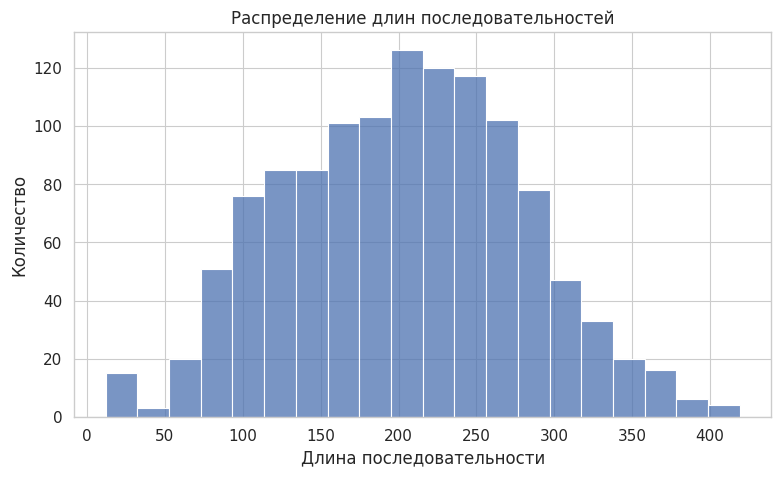

In [ ]:
# Определение наилучшего значения длины последовательности.
plt.figure(figsize=(9, 5))

sns.histplot(x=sequence_lengths)
plt.xlabel("Длина последовательности")
plt.ylabel("Количество")
plt.title("Распределение длин последовательностей")

plt.show()

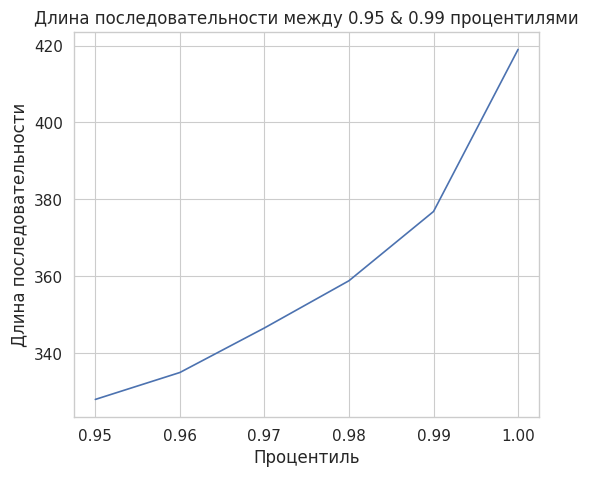

In [ ]:
# Выбор длины последовательности в соответствии с методом Elbow
low_level, high_level = 0.95, 1
plt.figure(figsize=(6, 5))

x = np.arange(low_level, high_level, 0.01)
y = np.quantile(a=np.array(sequence_lengths), q=x)

sns.lineplot(x=x, y=y)
plt.title(f"Длина последовательности между {low_level} & {round(high_level - 0.01, 2)} процентилями")
plt.xlabel("Процентиль")
plt.ylabel("Длина последовательности")

plt.show()

In [ ]:
# ~99% документов имеют длину последовательности менее 380, поэтому выбирается это значение для sequence_length.
sequence_length = 380

***3.2 Дополнение (Padding)***

In [ ]:
padding_documents = pad_sequences(encoding_documents, maxlen=sequence_length, padding="post", truncating="post")

print("Дополненные последовательности:")
print("Тип данных:", type(padding_documents), "Размерность:", padding_documents.shape)
print("Примеры значений:")
print(padding_documents)

Дополненные последовательности:
Тип данных: <class 'numpy.ndarray'> Размерность: (1208, 380)
Примеры значений:
[[ 104  826 2579 ...    0    0    0]
 [  58 1800   14 ...    0    0    0]
 [ 104  826    1 ...    0    0    0]
 ...
 [   6  333    6 ...    0    0    0]
 [  58    9   22 ...    0    0    0]
 [ 332   29  332 ...    0    0    0]]


***3.3 Векторы GloVe***

In [ ]:
%%time

# Загрузка векторов слов.
# Загрузка полного набора.
glove_vectors_index = dict()
with open(GLOVE_TXT, encoding="utf8") as glove_text_file:
    for line in glove_text_file.readlines():
        columns = line.split()
        word_current = columns[0]
        vec = np.array(columns[1:], dtype="float32")
        glove_vectors_index[word_current] = vec

CPU times: user 11.4 s, sys: 738 ms, total: 12.1 s
Wall time: 17.7 s


In [ ]:
print("Общее количество слов в GloVe:", len(glove_vectors_index.keys()))
print("Примеры векторов слов:")

result_table = PrettyTable(["Слово", "Предварительно обученный вектор"], align="l")
result_table.add_rows([[k, func_viewNValues(v, n=3)] for k, v in list(glove_vectors_index.items())[:5]])

print(result_table)

Общее количество слов в GloVe: 400000
Примеры векторов слов:
+-------+-----------------------------------------------------------------+
| Слово | Предварительно обученный вектор                                 |
+-------+-----------------------------------------------------------------+
| the   | [-0.038194, -0.24487, 0.72812, ..., -0.1459, 0.8278, 0.27062]   |
| ,     | [-0.10767, 0.11053, 0.59812, ..., -0.83155, 0.45293, 0.082577]  |
| .     | [-0.33979, 0.20941, 0.46348, ..., -0.23394, 0.47298, -0.028803] |
| of    | [-0.1529, -0.24279, 0.89837, ..., -0.591, 1.0039, 0.20664]      |
| to    | [-0.1897, 0.050024, 0.19084, ..., -0.39804, 0.47647, -0.15983]  |
+-------+-----------------------------------------------------------------+


In [ ]:
# Пропущенные слова.
missing_words = [word_current for word_current in word_index.keys() if word_current not in glove_vectors_index.keys()]
missing_words_count = len(missing_words)
missing_words_percent = round(missing_words_count / len(word_index.keys()) * 100, 1)
print(f"{missing_words_count} то есть, {missing_words_percent}% слов в словаре не имеют векторов GloVe.")

6794 то есть, 46.6% слов в словаре не имеют векторов GloVe.


In [ ]:
# Загрузка весов.

# Все нулевые векторы.
zero_vectors = np.zeros(OUTPUT_DIM)

weights = [zero_vectors]  # Для <PAD>

# Создание матрицы весов для слов в словаре.
for word_current in word_index.keys():
    weights.append(glove_vectors_index.get(word_current, zero_vectors).tolist())


weights = tf.convert_to_tensor(weights, dtype=tf.float32)
print("Тип данных весов:", weights.dtype)
print("Размерность весов:", weights.shape)

Тип данных весов: <dtype: 'float32'>
Размерность весов: (14588, 100)


***3.4 Косинусное подобие***

In [ ]:
# Пример 1
func_cosineSimilarity(glove_vectors_index, "Color", "Colour")

Вектор GloVe для `Color`: [-0.52516, 0.44118, -0.1273, ..., -0.88581, 0.075446, 0.040447]
Вектор GloVe для `Colour`: [-0.87662, 0.21689, -0.32172, ..., -0.53163, 0.0032544, -0.19457]
Косинусное сходство между 'Color' и 'Colour': 0.1234000027179718


In [ ]:
func_cosineSimilarity(glove_vectors_index, "Juice", "Table")

Вектор GloVe для `Juice`: [-0.51079, 0.30394, -0.42261, ..., -0.16562, 0.4512, 0.58224]
Вектор GloVe для `Table`: [-0.61454, 0.89693, 0.56771, ..., 0.2179, 1.4143, 0.40034]
Косинусное сходство между 'Juice' и 'Table': 0.723800003528595


***3.5 Функции POS***

In [ ]:
# Количество частей речи в документе.
# Этот признак целесообразно включить вместе с дополненными последовательностями
# в качестве входных данных для сети.

documents_dataframe.iloc[:, 3:18].astype("int32").head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB
0,5,14,3,6,6,8,2,35,11,2,8,46,32,2,14
1,37,44,9,19,12,37,4,93,1,6,33,34,50,3,42
2,27,40,2,21,18,25,2,88,9,4,11,42,57,5,31
3,21,42,11,21,4,31,4,74,8,12,35,22,34,6,47
4,28,48,6,35,20,35,4,118,9,20,19,45,69,5,55


**4. Настройка пользовательских Callbacks**

***4.1 Callback #1: Показатели производительности***¶

In [ ]:
# Callback для вычисления и печати оценки F1 для набора проверочных данных.
class ProductivityIndicators(callbacks.Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Остановка распространения Callbacks.
            return

        cl_probability = self.model.predict(self.X_test)
        y_prediction = np.argmax(cl_probability, axis=1)

        f1_scr = f1_score(self.y_test, y_prediction, average="micro")
        print("F1-score для проверочного набора данных:", round(f1_scr, 4))

***4.2 Callback #2. SaveBetterModel***

In [ ]:
# Callback для сохранения модели в каждой эпохе, если точность проверки
# улучшается по сравнению с предыдущей эпохой.

class SaveBetterModel(callbacks.ModelCheckpoint):
    def __init__(self, **kwargs):
        super().__init__(
            monitor="val_accuracy",
            verbose=2,
            save_best_only=True,
            mode="max",
            **kwargs,
        )

    def on_epoch_end(self, epoch, logs=None):
        # Для остановки распространения Callbacks.
        if self.model.stop_training:
            return

        super().on_epoch_end(epoch, logs)

***4.3 Callback #3. TerminateWhenNaN***

In [ ]:
class TerminateWhenNaN(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Остановка распространения Callbacks.
            return

        # Проверка уровня потерь для значений NaN.
        loss = logs.get("loss")
        if (loss is not None) and (np.isnan(loss) or np.isinf(loss)):
            print("Недействительная потеря. Жпоха прекращена:", epoch)
            # Сообщить следующему Callback о пропуске выполнения
            self.model.stop_training = True
            return

***4.4 Callback #4. DecayLearningRate***

In [ ]:
# Уменьшение скорости обучения на 10%, если точность проверки текущей эпохи ниже точности предыдущей эпохи.
# Уменьшение скорости обучения на 5% каждую третью эпоху.

class DecayLearningRate(callbacks.Callback):
    def __init__(self):
        self.prev_val_acc = 0  # previous validation accuracy.

    def __get_lr__(self):
        return float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

    def __set_lr__(self, new_lr):
        # tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
        new_lr = np.asarray(new_lr, dtype=x.dtype)
        self.model.optimizer.learning_rate.assign(new_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Stop propagation of callbacks.
            return

        curr_val_acc = logs.get("val_accuracy")
        lr = self.__get_lr__()
        if curr_val_acc < self.prev_val_acc:
            new_lr = decreaseBy(lr, 10)
            self.__set_lr__(new_lr)
            print("Current epoch validation accuracy:", round(curr_val_acc, 4))
            print("Previous epoch validation accuracy:", round(self.prev_val_acc, 4))
            print("Reducing learning rate by 10%. New learning rate:", round(new_lr, 6))
        elif not (epoch + 1) % 3:
            # Since epochs start at zero, add one to get current epoch number.
            new_lr = decreaseBy(lr, 5)
            self.__set_lr__(new_lr)
            print("Reducing learning rate by 5%. New learning rate:", round(new_lr, 6))

        # Save current validation accuracy value for next epoch.
        self.prev_val_acc = curr_val_acc

***4.5 Callback #5. TerminayeOnNoChange***

In [ ]:
# Ранняя остановка: обучение прекращается, когда точность проверки перестает улучшаться.

class TerminateOnNoChange(callbacks.EarlyStopping):
    def __init__(self, epochs):
        super().__init__(monitor="val_accuracy", patience=epochs, verbose=2, mode="max")

    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            # Остановка распространения Callbacks.
            return

        super().on_epoch_end(epoch, logs)

**5. Настройка обучения**

***5.1 Разделение выборки на обучающую, тестовую и валидационную (проверочную)***

In [ ]:
X = np.column_stack((padding_documents, documents_dataframe.iloc[:, 3:18].astype("int32")))
y = documents_dataframe["Категория"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train, X_cval, y_train, y_cval = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=42,
)

print("X обучающий набор данных:", X_train.shape)
print("y обучающий набор данных:", y_train.shape)

print("X набор данных кросс-валидации:", X_cval.shape)
print("y набор данных кросс-валидации:", y_cval.shape)

print("X тестовый набор данных:", X_test.shape)
print("y тестовый набор данных:", y_test.shape)


X обучающий набор данных: (634, 395)
y обучающий набор данных: (634,)
X набор данных кросс-валидации: (272, 395)
y набор данных кросс-валидации: (272,)
X тестовый набор данных: (302, 395)
y тестовый набор данных: (302,)


***5.2 Масштабирование***

In [ ]:
documents_scaler = StandardScaler()
documents_scaler.fit(X_train)

StandardScaler()

In [ ]:
scaled_X_train = documents_scaler.transform(X_train)  # Масштабирование X_train.
scaled_X_cval = documents_scaler.transform(X_cval)  # Масштабирование X_cval.
scaled_X_test = documents_scaler.transform(X_test)  # Масштабирование X_test.

print("Масштабированые значения X train (случайный пример):")
print(np.round(scaled_X_train[200:203], 3))

print("\nМасштабированые значения X cross-val (случайный пример):")
print(np.round(scaled_X_cval[115:118], 3))

print("\nМасштабированые значения X test (случайный пример):")
print(np.round(scaled_X_test[274:277], 3))

Масштабированые значения X train (случайный пример):
[[-0.48  -0.583 -0.148 ... -0.787 -1.098 -0.282]
 [-0.459 -0.528 -0.148 ... -1.281 -0.211 -0.536]
 [-0.421 -0.587 -0.421 ... -1.075  0.233 -0.853]]

Масштабированые значения X cross-val (случайный пример):
[[-0.428 -0.352 -0.181 ...  0.078 -1.098 -1.044]
 [-0.47  -0.282 -0.249 ...  0.078  0.233  0.923]
 [-0.421  1.585 -0.554 ... -0.869  1.564  0.542]]

Масштабированые значения X test (случайный пример):
[[-0.292 -0.432 -0.591 ...  1.724  2.451  1.367]
 [-0.476 -0.247 -0.591 ...  3.124 -0.211 -0.663]
 [-0.163 -0.304 -0.478 ... -1.898 -1.098 -2.059]]


Примечание: Масштабирование не использовалось, поскольку оно не показало увеличения точности свыше 35%.

***5.3 Изменение размерности обучающих данных***

In [ ]:
# Расширение размерности наборов данных.

# Примечание: Для включения масштабирования необходимо заменить
# X_train, X_cval и X_test в коде ниже на scaled_X_train, scaled_X_cval и scaled_X_test.

expand_X_train = np.expand_dims(X_train, axis=2)  # Расширенный X_train.
expand_X_cval = np.expand_dims(X_cval, axis=2)  # Расширенный X_cval.
expand_X_test = np.expand_dims(X_test, axis=2)  # Расширенный X_test.

print("Расширенный обучающий набор данных X train:", expand_X_train.shape)
print("Расширенный набор данных кросс-валидации:", expand_X_cval.shape)
print("Расширенный тестовый набор данных:", expand_X_test.shape)

Расширенный обучающий набор данных X train: (634, 395, 1)
Расширенный набор данных кросс-валидации: (272, 395, 1)
Расширенный тестовый набор данных: (302, 395, 1)


**6. Работа с моделью (моделирование)**

In [ ]:
# Сброс всех состояний, сгенерированных Keras.
tf.keras.backend.clear_session()

***6.1 Определение архитектуры модели***

In [ ]:
rows, cols = X_train.shape

# ВХодной слой
inputs = Input(shape=(cols,), name="Input_Documents_Text")

# Embedding слой.
x = Embedding(
    vocabulary_size + 1,
    OUTPUT_DIM,
    input_length=cols,
    name="EmbeddingLayer1",
    weights=[weights],
    trainable=False,
)(inputs)

# Три параллельных конволючионных слоя с различным размером фильтра + Max pooling.
f1 = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_F1_Filters")(x)
f2 = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_F2_Filters")(x)
f3 = Conv1D(16, 3, padding="same", activation="relu", name="Conv1D_F3_Filters")(x)
f1f2f3 = tf.keras.layers.concatenate([f1, f2, f3], name="Concatenate1_F1F2F3")
x = MaxPool1D(3, name="MaxPoolLayer1")(f1f2f3)

# Три параллельных конволючионных слоя с различным размером фильтра + Max pooling.
f4 = Conv1D(2, 3, padding="same", activation="relu", name="Conv1D_F4_Filters")(x)
f5 = Conv1D(4, 3, padding="same", activation="relu", name="Conv1D_F5_Filters")(x)
f6 = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_F6_Filters")(x)
f4f5f6 = tf.keras.layers.concatenate([f4, f5, f6], name="Concatenate2_F4F5F6")
x = MaxPool1D(3, name="MaxPoolLayer2")(f4f5f6)

x = Conv1D(8, 3, padding="same", activation="relu", name="Conv1D_P_Filters")(x)
x = Flatten(name="Flatten")(x)
x = Dropout(0.25, name="DropOut")(x)
x = Dense(30, activation="relu", name="Dense1")(x)

outputs = Dense(TYPES_COUNT, activation="softmax", name="Output_layer")(x)

work_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Documents_Classification")
work_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Documents_Classification"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Documents_Te… │ (None, 395)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingLayer1     │ (None, 395, 100)  │  1,458,800 │ Input_Documents_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F1_Filters   │ (None, 395, 4)    │      1,204 │ EmbeddingLayer1[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F2_Filters   │ (None, 395, 8)    │      2,408 │ EmbeddingLayer1[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F3_Filters   │ (None, 395, 16)   │      4,816 │ EmbeddingLayer1[… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate1_F1F2F3 │ (None, 395, 28)   │          0 │ Conv1D_F1_Filter… │
│ (Concatenate)       │                   │            │ Conv1D_F2_Filter… │
│                     │                   │            │ Conv1D_F3_Filter… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPoolLayer1       │ (None, 131, 28)   │          0 │ Concatenate1_F1F… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F4_Filters   │ (None, 131, 2)    │        170 │ MaxPoolLayer1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F5_Filters   │ (None, 131, 4)    │        340 │ MaxPoolLayer1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_F6_Filters   │ (None, 131, 8)    │        680 │ MaxPoolLayer1[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate2_F4F5F6 │ (None, 131, 14)   │          0 │ Conv1D_F4_Filter… │
│ (Concatenate)       │                   │            │ Conv1D_F5_Filter… │
│                     │                   │            │ Conv1D_F6_Filter… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPoolLayer2       │ (None, 43, 14)    │          0 │ Concatenate2_F4F… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_P_Filters    │ (None, 43, 8)     │        344 │ MaxPoolLayer2[0]… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 344)       │          0 │ Conv1D_P_Filters… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DropOut (Dropout)   │ (None, 344)       │          0 │ Flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 30)        │     10,350 │ DropOut[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_layer        │ (None, 4)         │        124 │ Dense1[0][0]      │
│ (Dense)             │                   │            │                 

 Total params: 1,479,236 (5.64 MB)

 Trainable params: 20,436 (79.83 KB)

 Non-trainable params: 1,458,800 (5.56 MB)

***6.2 Отображение архитектуры модели***

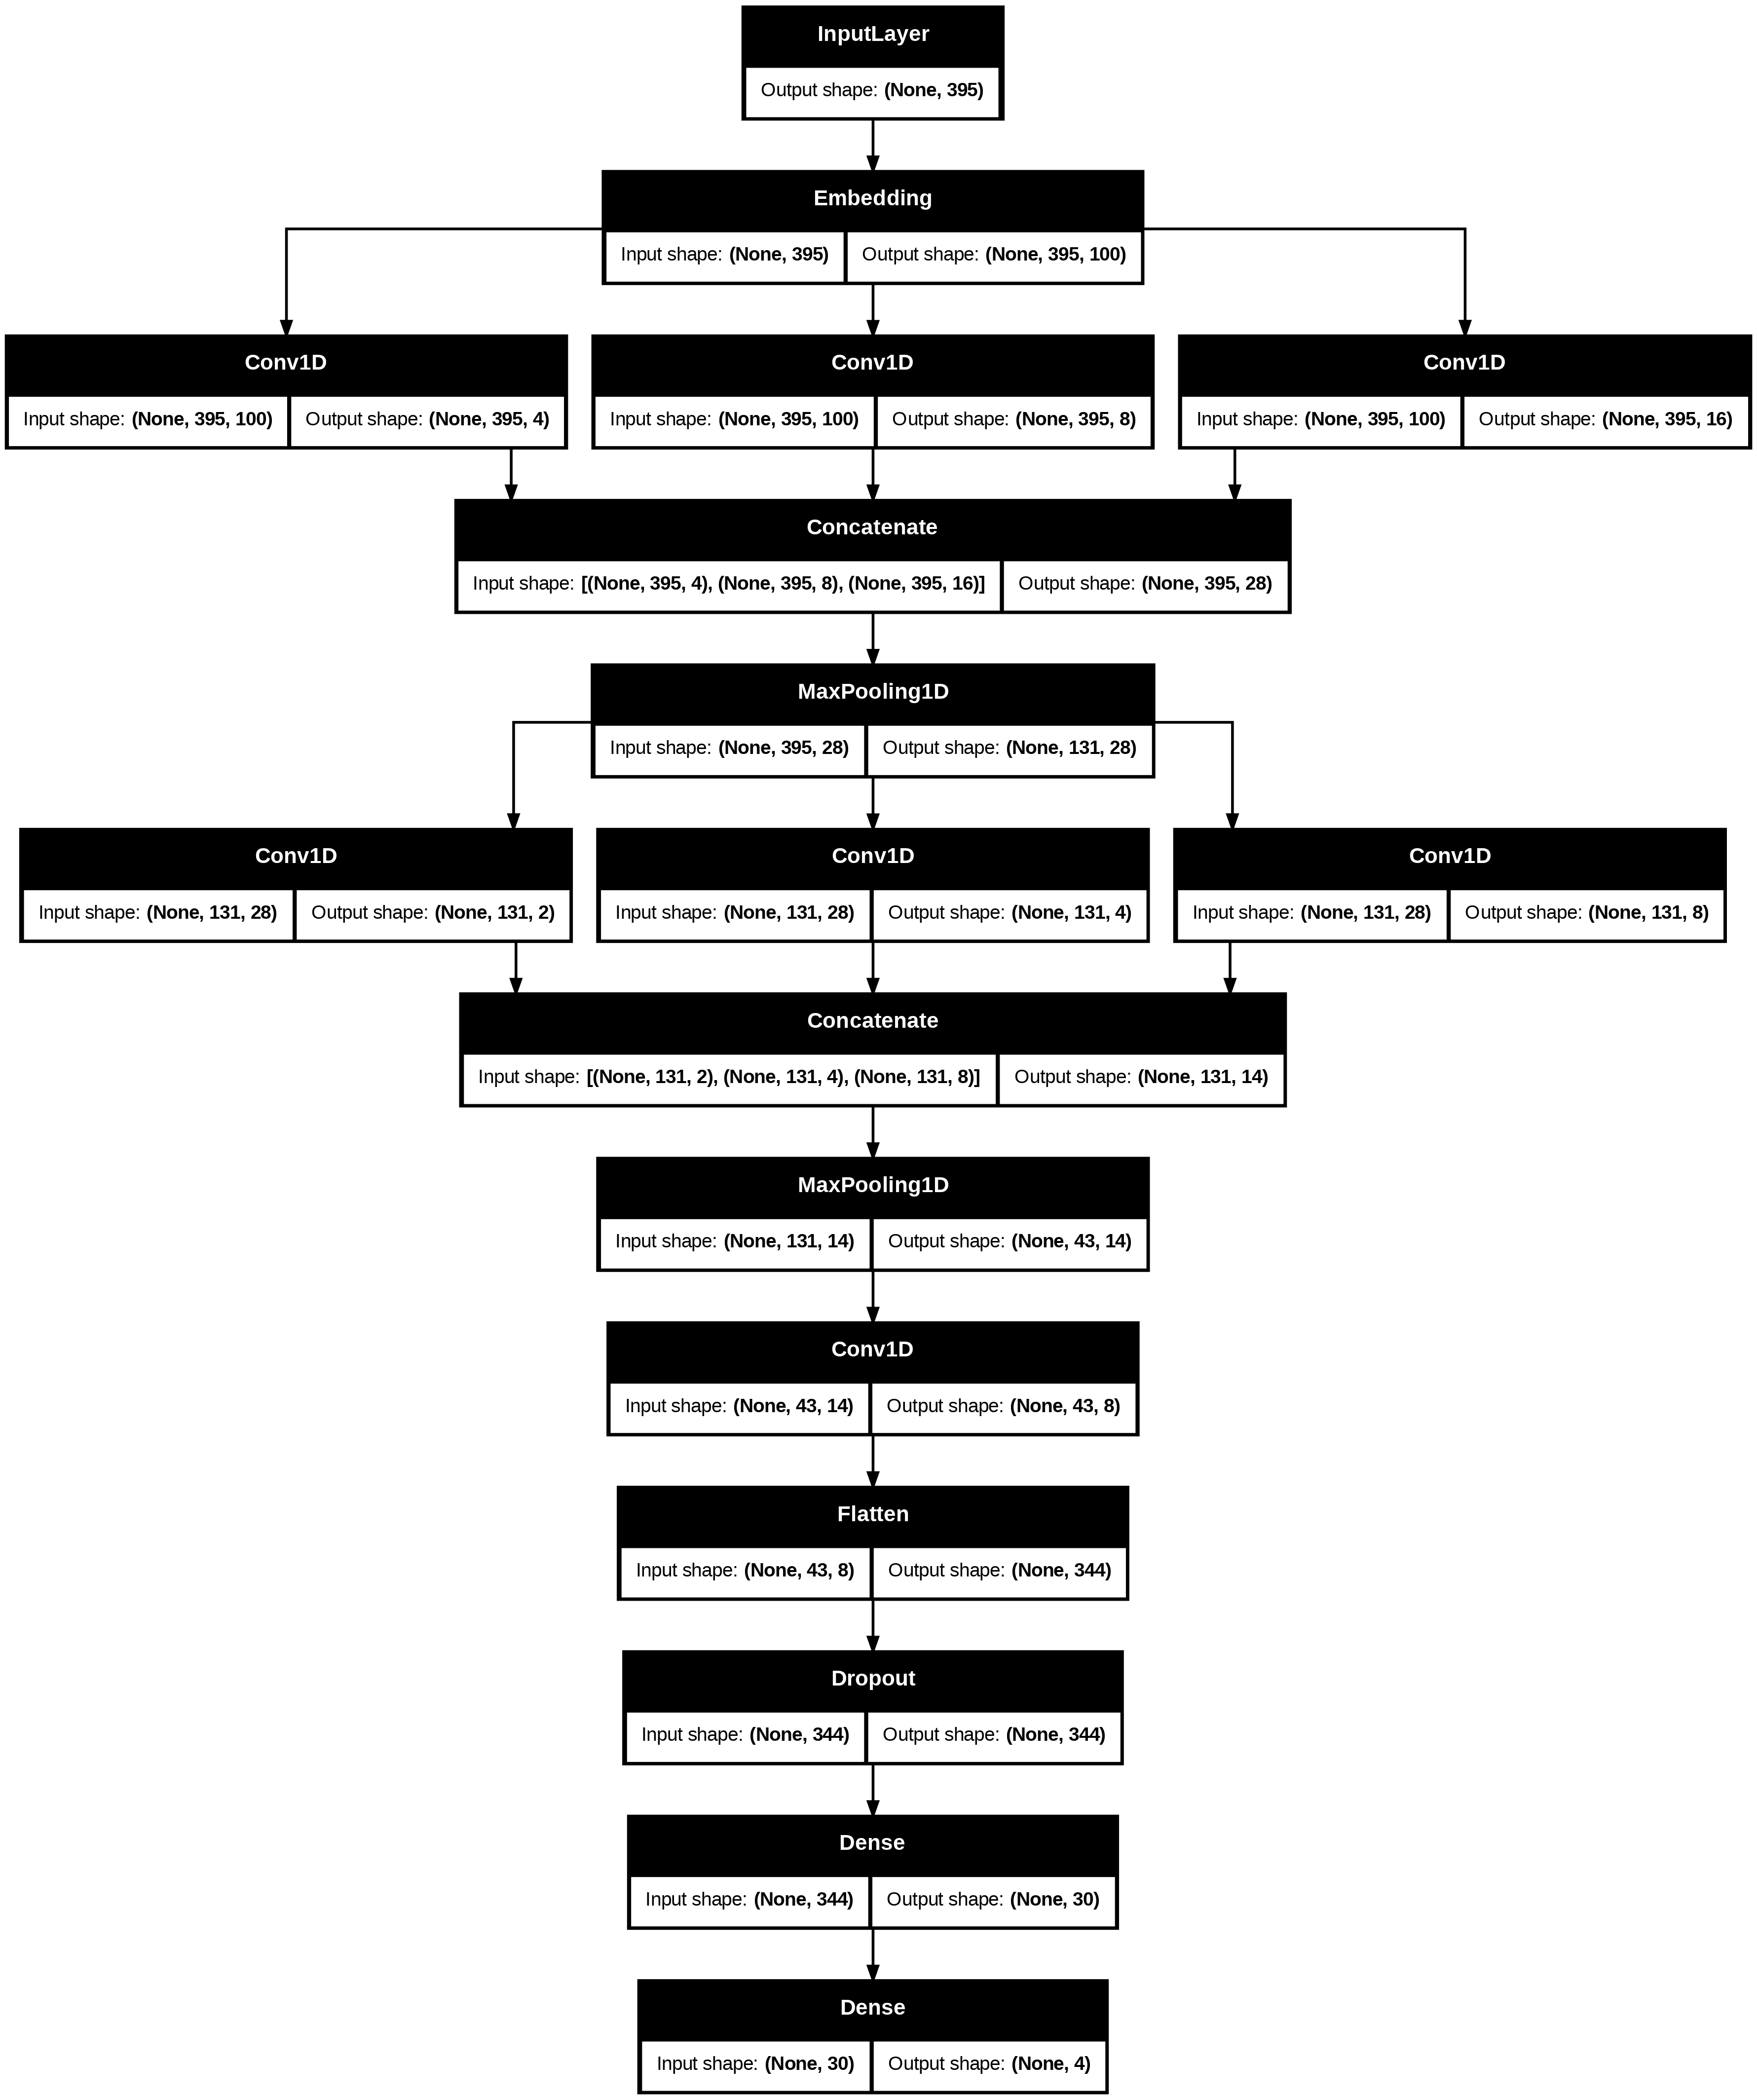

In [ ]:
utils.plot_model(work_model, "Documents_Classification_Model.png", show_shapes=True)

***6.3 Компиляция модели***

In [ ]:
work_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.002),
    metrics=["accuracy"],
)

***6.4 Обучение модели***

In [ ]:
# Обработка несбалансированного набора данных
types_weights = {}
for types, count in y_train.value_counts().sort_index().items():
    types_weights[types] = round(1 - (count / len(y_train)), 2)  # Вариант 1
    # types_weights[cls] = (1 / count) * (len(y_train) / 2.0)  # Вариант 2

print("Веса типов документов:", types_weights)

Веса типов документов: {0: 0.75, 1: 0.76, 2: 0.75, 3: 0.74}


In [ ]:
# Запуск обучения модели
train_history = work_model.fit(
    x=expand_X_train,
    y=y_train,
    batch_size=89,
    epochs=30,
    verbose=2,
    callbacks=[
        callbacks.TensorBoard(LOGS_DIR, histogram_freq=1),
        TerminateWhenNaN(),
        ProductivityIndicators(expand_X_cval, y_cval),
        DecayLearningRate(),
        SaveBetterModel(filepath=MODEL_FILE),
        TerminateOnNoChange(epochs=PATIENCE),
    ],
    validation_data=(expand_X_cval, y_cval),
    # class_weight=cls_weights,
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
F1-score для проверочного набора данных: 0.2463

Epoch 1: val_accuracy improved from -inf to 0.24632, saving model to /content/drive/My Drive/Data/models/epoch-01_accuracy-0.2463.keras
8/8 - 7s - 920ms/step - accuracy: 0.2603 - loss: 1.4513 - val_accuracy: 0.2463 - val_loss: 1.3874
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
F1-score для проверочного набора данных: 0.2831

Epoch 2: val_accuracy improved from 0.24632 to 0.28309, saving model to /content/drive/My Drive/Data/models/epoch-02_accuracy-0.2831.keras
8/8 - 2s - 267ms/step - accuracy: 0.3155 - loss: 1.3633 - val_accuracy: 0.2831 - val_loss: 1.3938
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
F1-score для проверочного набора данных: 0.3088
Reducing learning rate by 5%. New learning rate: 0.0019

Epoch 3: val_accuracy improved from 0.28309 to 0.30882, saving model to /content/drive/My Drive/Data/models/epoch-03_accuracy-0.3088.keras
8/8 - 2s - 269ms/step - accuracy: 0.3470

***6.5 Статистика обучения модели***

<function matplotlib.pyplot.show(close=None, block=None)>

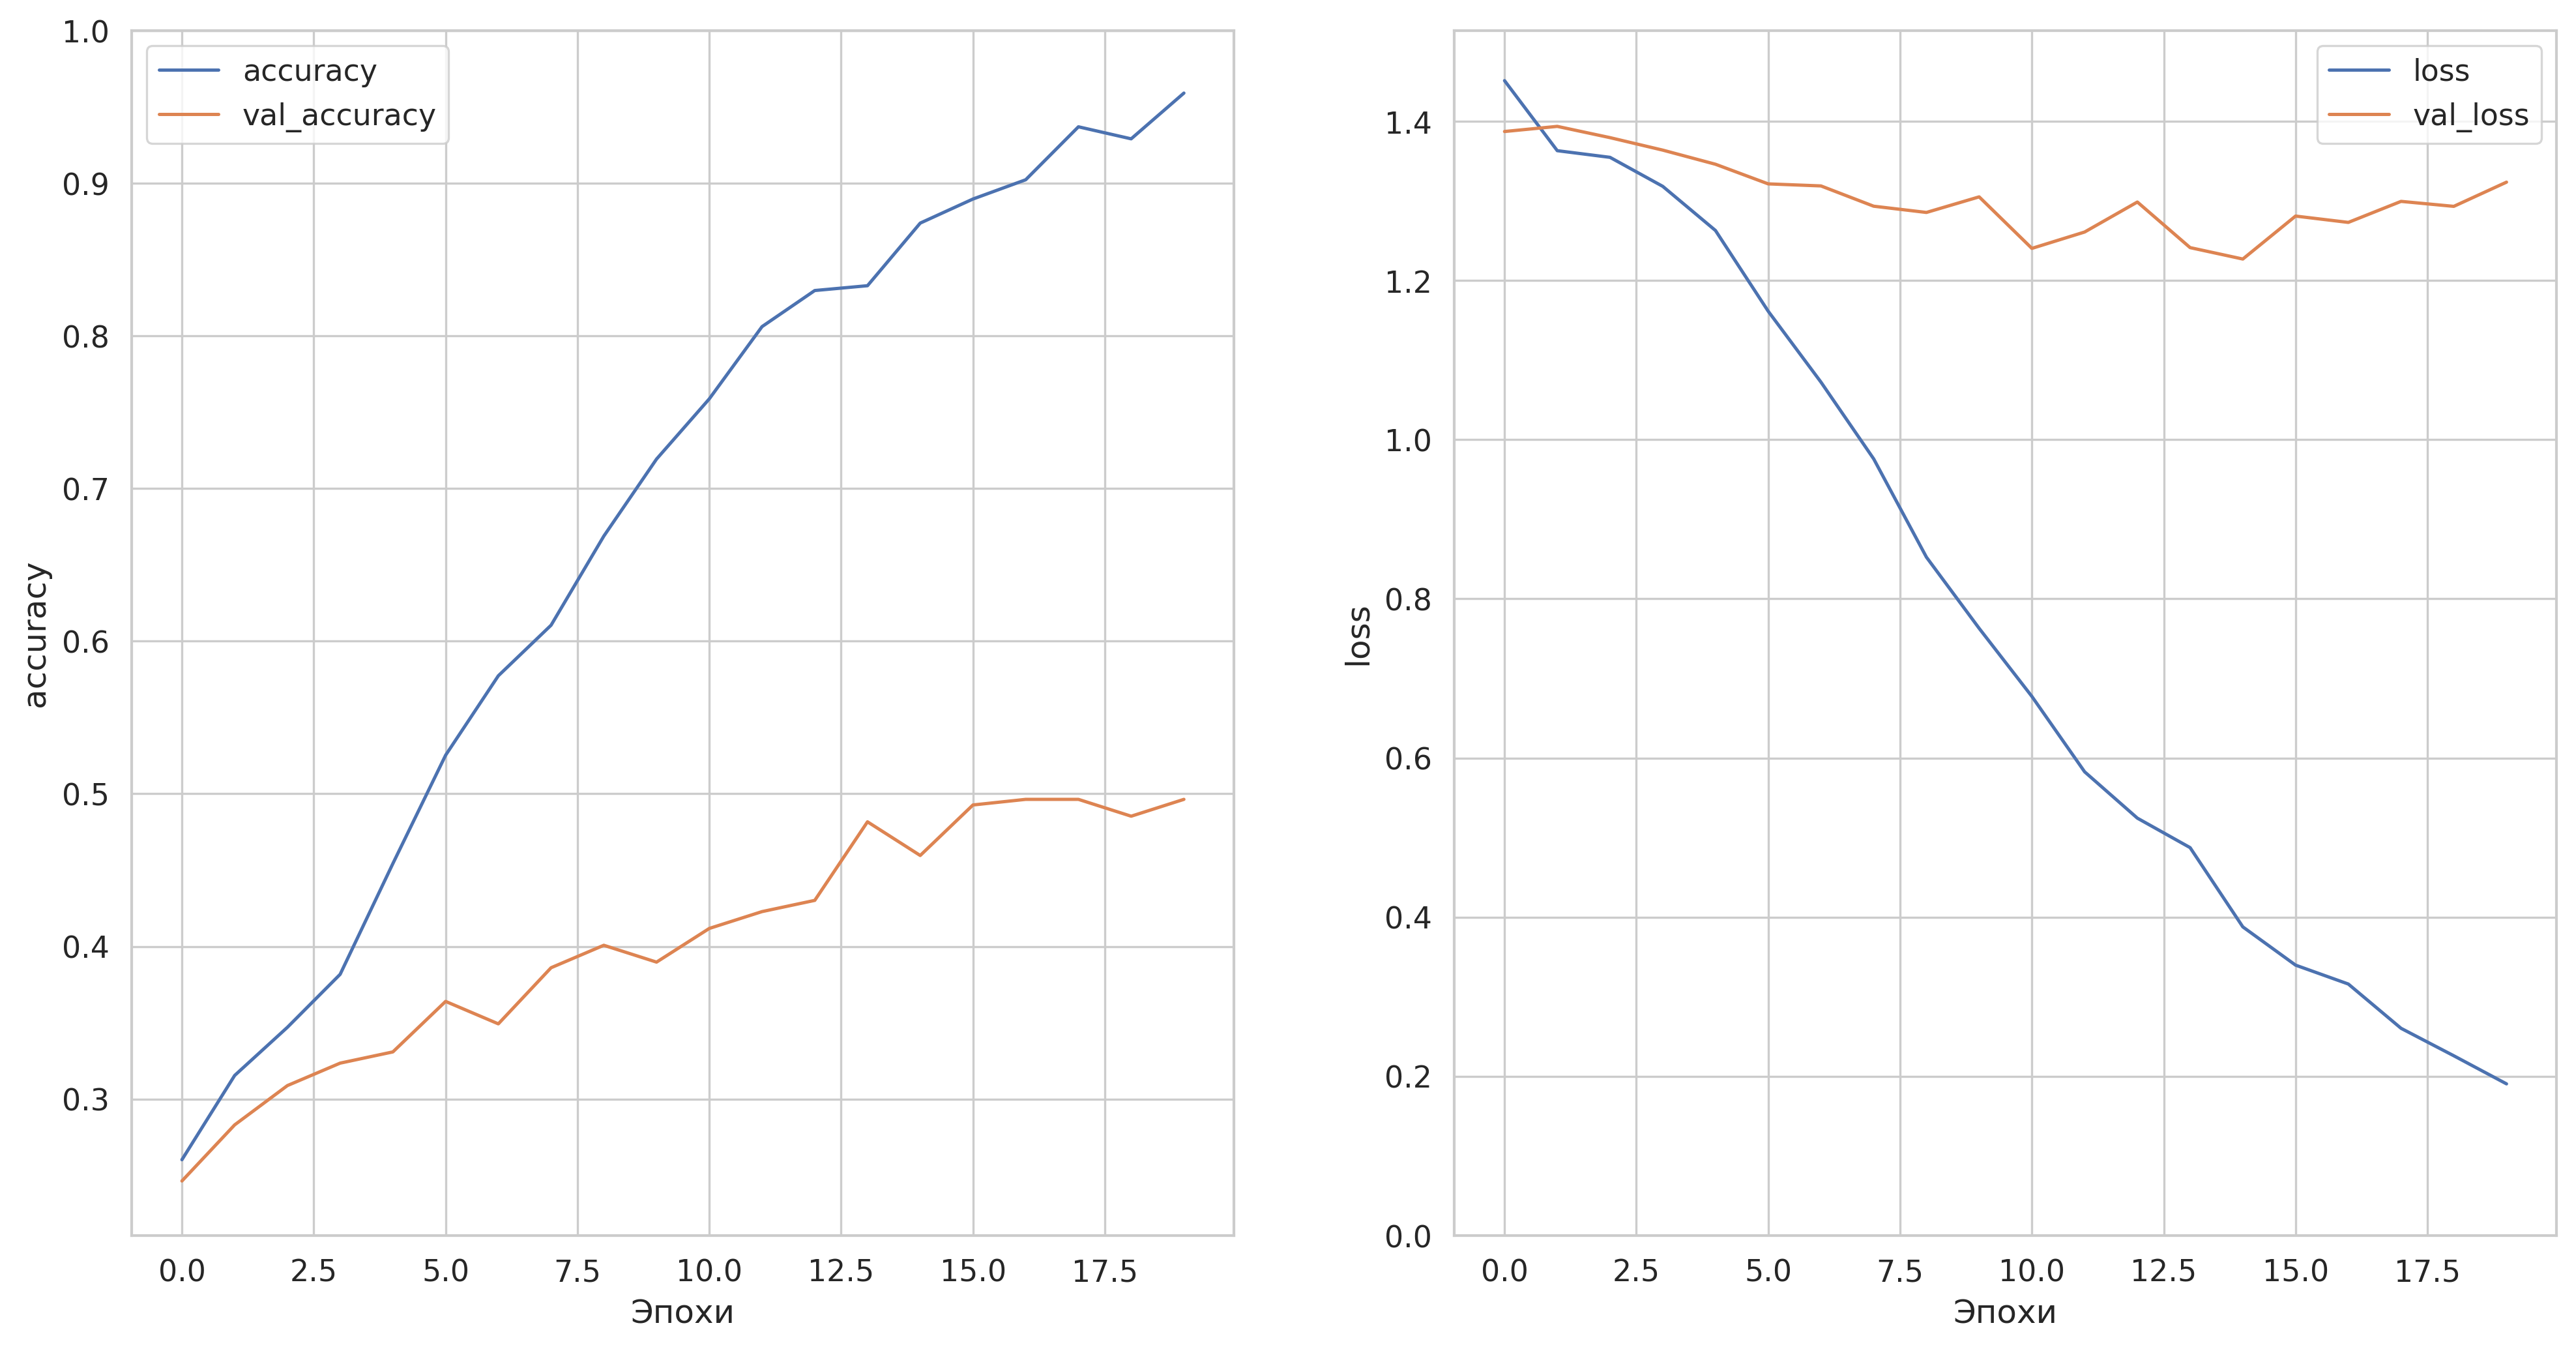

In [ ]:
#===Функция отрисовки графиков обучения модели
def func_drawGraphics(history_loc, metric_loc):
    plt.plot(history_loc.history[metric_loc])
    plt.plot(history_loc.history['val_'+metric_loc], '')
    plt.xlabel("Эпохи")
    plt.ylabel(metric_loc)
    plt.legend([metric_loc, 'val_'+metric_loc])

plt.figure(figsize=(16, 8), dpi=300)
plt.subplot(1, 2, 1)
func_drawGraphics(train_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
func_drawGraphics(train_history, 'loss')
plt.ylim(0, None)

plt.show

***6.6 Проверка модели***

In [ ]:
work_model.evaluate(expand_X_test, y_test, verbose=2)

10/10 - 0s - 20ms/step - accuracy: 0.5232 - loss: 1.3228


[1.3228473663330078, 0.5231788158416748]

**7. Показатели производительности**

***7.1 Матрица путаницы***

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


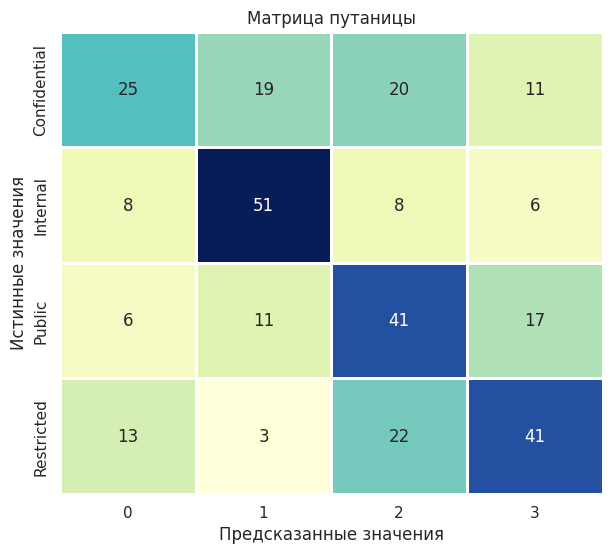

In [ ]:
# Предсказание меток класса y_test
types_probability = work_model.predict(expand_X_test)
y_pred = np.argmax(types_probability, axis=1)

# Вычисление матрицы путаницы
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred, TYPES_COUNT).numpy()

# Вывод матрицы путаницы
plt.figure(figsize=(7, 6))
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=False,
    linecolor="white",
    linewidths=1,
    yticklabels=types_map.keys(),
)
plt.title("Матрица путаницы")
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")

plt.show()

In [ ]:
new_data = [02]
preds = work_model(new_data, return_all_scores=True)
preds

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (ipython-input-3968555132.py, line 1)